In [2]:
import torch
import time
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim, autograd
from torch.nn import functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
from sklearn.utils import shuffle as skshuffle
from math import *
from backpack import backpack, extend
from backpack.extensions import KFAC
from sklearn.metrics import roc_auc_score
import scipy
from tqdm import tqdm, trange
import pytest
import matplotlib.pyplot as plt
from DirLPA_utils import * 

print("pytorch version: ", torch.__version__)
print("cuda available: ", torch.cuda.is_available())

s = 127
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

pytorch version:  1.2.0
cuda available:  True


# Train Cifar10 on Resnet32

In [3]:
BATCH_SIZE_TRAIN_CIFAR10 = 128
BATCH_SIZE_TEST_CIFAR10 = 128

In [4]:
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


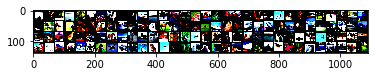

In [5]:
"""
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
"""

transform_base = [transforms.ToTensor()]

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    ] + transform_base)

transform_test = transforms.Compose(transform_base)
transform_train = transforms.RandomChoice([transform_train, transform_test])

trainset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=True,
                                        download=True, transform=transform_train)

train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
CIFAR10_train_dataset, CIFAR10_val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

CIFAR10_train_loader = torch.utils.data.DataLoader(CIFAR10_train_dataset, batch_size=BATCH_SIZE_TRAIN_CIFAR10,
                                          shuffle=False)

CIFAR10_val_loader = torch.utils.data.DataLoader(CIFAR10_val_dataset, batch_size=BATCH_SIZE_TRAIN_CIFAR10,
                                          shuffle=False)

CIFAR10_test = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=False,
                                       download=True, transform=transform_test)
CIFAR10_test_loader = torch.utils.data.DataLoader(CIFAR10_test, batch_size=BATCH_SIZE_TEST_CIFAR10,
                                         shuffle=False)

CIFAR10_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(CIFAR10_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR10/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

In [6]:
#load in CIFAR100
BATCH_SIZE_TRAIN_CIFAR100 = 128
BATCH_SIZE_TEST_CIFAR100 = 128

CIFAR100_train = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=True,
                                       download=True, transform=transform_test)
CIFAR100_train_loader = torch.utils.data.DataLoader(CIFAR100_train, batch_size=BATCH_SIZE_TRAIN_CIFAR100,
                                         shuffle=False)

CIFAR100_test = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=False,
                                       download=True, transform=transform_test)
CIFAR100_test_loader = torch.utils.data.DataLoader(CIFAR100_test, batch_size=BATCH_SIZE_TEST_CIFAR100,
                                         shuffle=False)

CIFAR100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# load SVHN
BATCH_SIZE_TRAIN_SVHN = 128
BATCH_SIZE_TEST_SVHN = 128

train_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='train',
                             download=True, transform=transform_train)

test_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='test',
                             download=True, transform=transform_test)

train_loader_SVHN = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TRAIN_SVHN)
test_loader_SVHN = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TEST_SVHN)
print("everything loaded")

0it [00:00, ?it/s]

 14%|█▍        | 25944064/182040794 [00:07<00:44, 3471080.90it/s]

KeyboardInterrupt: 

# Train CIFAR10 on ResNet18

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 32, 32])
(3, 138, 1090)


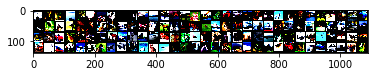

In [11]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE_TRAIN_CIFAR10, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE_TEST_CIFAR10, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(CIFAR10_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR10/4)
print(images.size())
imshow(torchvision.utils.make_grid(images, nrow=nrow))

In [9]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.fc = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def phi(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out
    
    def forward(self, x):
        out = self.phi(x)
        out = self.fc(out)
        return(out)


def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes=num_classes)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
CIFAR10_model = ResNet18().to(device)
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CIFAR10_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

In [12]:
# Training
def train(net, epoch, optimizer, trainloader, filename):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    
    print("train loss: ", train_loss)
    print("train accuracy: ", correct/total)
    print("saving model at: {}".format(filename))
    torch.save(net.state_dict(), filename)

In [13]:
def test(net, epoch, testloader):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
        print("test loss: ", test_loss)
        print("test accuracy: ", correct/total)

In [14]:
def train_all():
    CIFAR10_path = 'weights/cifar10_resnet18_SGD.pth'
    lr = 0.1
    epoch = 0
    for e in [100, 50, 50]:
        print("current learning rate: ", lr)
        for _ in range(e):
            optimizer = optim.SGD(CIFAR10_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
            train(CIFAR10_model, epoch, optimizer, trainloader, CIFAR10_path)
            test(CIFAR10_model, epoch, testloader)
            epoch += 1
        lr /= 10

In [15]:
train_all()

current learning rate:  0.1

Epoch: 0
train loss:  735.2782756090164
train accuracy:  0.32482
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  122.92022550106049
test accuracy:  0.4207

Epoch: 1
train loss:  549.5818940401077
train accuracy:  0.48396
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  102.8718353509903
test accuracy:  0.5241

Epoch: 2
train loss:  441.67920756340027
train accuracy:  0.59368
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  120.26511776447296
test accuracy:  0.5313

Epoch: 3
train loss:  363.2937567830086
train accuracy:  0.67208
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  73.24164694547653
test accuracy:  0.6793

Epoch: 4
train loss:  307.59092301130295
train accuracy:  0.72514
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  62.32203954458237
test accuracy:  0.7245

Epoch: 5
train loss:  259.6400728225708
train accuracy:  0.7697
saving model at: weights/cifar10_resnet18_SGD.pth
test los

In [16]:
##### if you already have a trained model ##############
CIFAR10_PATH = 'weights/cifar10_resnet18_SGD.pth'
CIFAR10_model = ResNet18().to(device)
print("loading model from: {}".format(CIFAR10_PATH))
CIFAR10_model.load_state_dict(torch.load(CIFAR10_PATH))#, map_location=torch.device('cpu')))
#test the model
test(CIFAR10_model, 0, testloader)

loading model from: weights/cifar10_resnet18_SGD.pth
test loss:  15.137750057503581
test accuracy:  0.9518


In [17]:
def Diag_second_order(model, train_loader, var0 = 10, device='cpu'):

    W = list(model.parameters())[-2]
    b = list(model.parameters())[-1]
    m, n = W.shape
    print("n: {} inputs to linear layer with m: {} classes".format(n, m))
    lossfunc = torch.nn.CrossEntropyLoss()

    tau = 1/var0

    extend(lossfunc, debug=False)
    extend(model.fc, debug=False)

    with backpack(DiagHessian()):

        max_len = len(train_loader)
        weights_cov = torch.zeros(max_len, m, n, device=device)
        biases_cov = torch.zeros(max_len, m, device=device)

        for batch_idx, (x, y) in enumerate(train_loader):

            if device == 'cuda':
                x, y = x.cuda(), y.cuda()

            model.zero_grad()
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                W_ = W.diag_h
                b_ = b.diag_h

                #add_prior: since it will be flattened later we can just add the prior like that
                W_ += tau * torch.ones(W_.size(), device=device)
                b_ += tau * torch.ones(b_.size(), device=device)


            weights_cov[batch_idx] = W_
            biases_cov[batch_idx] = b_

            print("Batch: {}/{}".format(batch_idx, max_len))

        print(len(weights_cov))
        C_W = torch.mean(weights_cov, dim=0)
        C_b = torch.mean(biases_cov, dim=0)

    # Predictive distribution
    with torch.no_grad():
        M_W_post = W.t()
        M_b_post = b

        C_W_post = C_W
        C_b_post = C_b
        
    print("M_W_post size: ", M_W_post.size())
    print("M_b_post size: ", M_b_post.size())
    print("C_W_post size: ", C_W_post.size())
    print("C_b_post size: ", C_b_post.size())

    return(M_W_post, M_b_post, C_W_post, C_b_post)

In [18]:
M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D = Diag_second_order(model=CIFAR10_model,
                                                               train_loader=trainloader,
                                                               var0 = 10,
                                                               device='cuda')

n: 512 inputs to linear layer with m: 10 classes
Batch: 0/391
Batch: 1/391
Batch: 2/391
Batch: 3/391
Batch: 4/391
Batch: 5/391
Batch: 6/391
Batch: 7/391
Batch: 8/391
Batch: 9/391
Batch: 10/391
Batch: 11/391
Batch: 12/391
Batch: 13/391
Batch: 14/391
Batch: 15/391
Batch: 16/391
Batch: 17/391
Batch: 18/391
Batch: 19/391
Batch: 20/391
Batch: 21/391
Batch: 22/391
Batch: 23/391
Batch: 24/391
Batch: 25/391
Batch: 26/391
Batch: 27/391
Batch: 28/391
Batch: 29/391
Batch: 30/391
Batch: 31/391
Batch: 32/391
Batch: 33/391
Batch: 34/391
Batch: 35/391
Batch: 36/391
Batch: 37/391
Batch: 38/391
Batch: 39/391
Batch: 40/391
Batch: 41/391
Batch: 42/391
Batch: 43/391
Batch: 44/391
Batch: 45/391
Batch: 46/391
Batch: 47/391
Batch: 48/391
Batch: 49/391
Batch: 50/391
Batch: 51/391
Batch: 52/391
Batch: 53/391
Batch: 54/391
Batch: 55/391
Batch: 56/391
Batch: 57/391
Batch: 58/391
Batch: 59/391
Batch: 60/391
Batch: 61/391
Batch: 62/391
Batch: 63/391
Batch: 64/391
Batch: 65/391
Batch: 66/391
Batch: 67/391
Batch: 68

In [19]:
def get_in_dist_values(py_in, targets):
    acc_in = np.mean(np.argmax(py_in, 1) == targets)
    #prob_correct = np.choose(targets, py_in.T).mean()
    prob_correct = py_in[targets].mean()
    average_entropy = -np.sum(py_in*np.log(py_in+1e-8), axis=1).mean()
    MMC = py_in.max(1).mean()
    return(acc_in, prob_correct, average_entropy, MMC)

def get_out_dist_values(py_in, py_out, targets):
    average_entropy = -np.sum(py_out*np.log(py_out+1e-8), axis=1).mean()
    acc_out = np.mean(np.argmax(py_out, 1) == targets)
    if max(targets) > len(py_in[0]):
        targets = np.array(targets)
        targets[targets >= len(py_in[0])] = 0
    #prob_correct = np.choose(targets, py_out.T).mean()
    prob_correct = py_out[targets].mean()
    labels = np.zeros(len(py_in)+len(py_out), dtype='int32')
    labels[:len(py_in)] = 1
    examples = np.concatenate([py_in.max(1), py_out.max(1)])
    auroc = roc_auc_score(labels, examples)
    MMC = py_out.max(1).mean()
    return(acc_out, prob_correct, average_entropy, MMC, auroc)

In [20]:
def get_Gaussian_output_old(x, mu_w, mu_b, sigma_w, sigma_b):
    #get the distributions per class
    batch_size = x.size(0)
    num_classes = len(mu_b)
    #print("batch_size, num_classes: ", batch_size, num_classes)
    mu_batch = torch.zeros(batch_size, num_classes)
    sigma_batch = torch.zeros(batch_size, num_classes, num_classes)
    for i in range(batch_size):
        per_class_sigmas = torch.zeros(num_classes)
        for j in range(num_classes):
            #create a diagonal Hessian
            hess = torch.diag(sigma_w[j])
            #b = x[i] @ hess @ x[i].t()
            #a = sigma_b[i]
            per_class_sigmas[j] = x[i] @ hess @ x[i].t() + sigma_b[j]

        #print("sizes: ", mu_w.size(), x[i].size(), mu_b.size())
        per_class_mus = x[i] @ mu_w + mu_b
        mu_batch[i] = per_class_mus
        sigma_batch[i] = torch.diag(per_class_sigmas)

    return(mu_batch, sigma_batch)

In [21]:
def get_Gaussian_output(x, mu_w, mu_b, sigma_w, sigma_b):
    #get the distributions per class
    batch_size = x.size(0)
    num_classes = mu_b.size(0)
    
    # get mu batch
    mu_w_batch = mu_w.repeat(batch_size, 1, 1)
    mu_b_batch = mu_b.repeat(batch_size, 1)
    mu_batch = torch.bmm(x.view(batch_size, 1, -1), mu_w_batch).view(batch_size, -1) + mu_b_batch
    
    #get sigma batch
    sigma_w_batch = sigma_w.repeat(batch_size, 1, 1)
    sigma_b_batch = sigma_b.repeat(batch_size, 1)
    sigmas_diag = torch.zeros(batch_size, num_classes, device='cuda')
    for j in range(num_classes):
        h1 = x * sigma_w_batch[:, j]
        helper = torch.matmul(h1.view(batch_size, 1, -1), x.view(batch_size, -1, 1))
        helper = helper.view(-1) + sigma_b_batch[:,j]
        sigmas_diag[:,j] = helper
        
    sigma_batch = torch.stack([torch.diag(x) for x in sigmas_diag])

    
    return(mu_batch, sigma_batch)


In [22]:
@torch.no_grad()
def predict_diagonal_sampling(model, test_loader, M_W_post, M_b_post, C_W_post, C_b_post, n_samples, verbose=False, cuda=False, timing=False):
    py = []
    max_len = len(test_loader)
    if timing:
        time_sum = 0

    for batch_idx, (x, y) in enumerate(test_loader):

        if cuda:
            x, y = x.cuda(), y.cuda()

        phi = model.phi(x)

        mu, Sigma = get_Gaussian_output(phi, M_W_post, M_b_post, C_W_post, C_b_post)
        #print("mu size: ", mu.size())
        #print("sigma size: ", Sigma.size())

        post_pred = MultivariateNormal(mu, Sigma)

        # MC-integral
        t0 = time.time()
        py_ = 0

        for _ in range(n_samples):
            f_s = post_pred.rsample()
            py_ += torch.softmax(f_s, 1)

        py_ /= n_samples
        py_ = py_.detach()

        py.append(py_)
        t1 = time.time()
        if timing:
            time_sum += (t1 - t0)

        if verbose:
            print("Batch: {}/{}".format(batch_idx, max_len))

    if timing: print("time used for sampling with {} samples: {}".format(n_samples, time_sum))
    
    return torch.cat(py, dim=0)

In [23]:
targets_CIFAR10 = testset.targets
targets_CIFAR100 = CIFAR100_test.targets
targets_SVHN = []
for x,y in test_loader_SVHN:
    targets_SVHN.append(y)
targets_SVHN = torch.cat(targets_SVHN).numpy()

# MAP estimate

In [24]:
CIFAR10_test_in_MAP = predict_MAP(CIFAR10_model, testloader, cuda=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_MAP = predict_MAP(CIFAR10_model, CIFAR100_test_loader, cuda=True).cpu().numpy()
CIFAR10_test_out_SVHN_MAP = predict_MAP(CIFAR10_model, test_loader_SVHN, cuda=True).cpu().numpy()

In [25]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(CIFAR10_test_in_MAP, targets_CIFAR10)
acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP = get_out_dist_values(CIFAR10_test_in_MAP, CIFAR10_test_out_CIFAR100_MAP, targets_CIFAR100)
acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP = get_out_dist_values(CIFAR10_test_in_MAP, CIFAR10_test_out_SVHN_MAP, targets_SVHN)

In [26]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'CIFAR10', 'MAP')
print_out_dist_values(acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP, 'CIFAR100', 'MAP')
print_out_dist_values(acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP, 'SVHN', 'MAP')

[In, MAP, CIFAR10] Accuracy: 0.952; average entropy: 0.066;     MMC: 0.979; Prob @ correct: 0.100
[Out-MAP, KFAC, CIFAR100] Accuracy: 0.009; Average entropy: 0.497;    MMC: 0.828; AUROC: 0.874; Prob @ correct: 0.100
[Out-MAP, KFAC, SVHN] Accuracy: 0.112; Average entropy: 0.604;    MMC: 0.793; AUROC: 0.925; Prob @ correct: 0.100


In [86]:
#MAP estimate
#seeds are 123,124,125,126,127
acc_in = [0.953, 0.952, 0.952, 0.950, 0.952]
mmc_in = [0.979, 0.978, 0.979, 0.976, 0.979]
mmc_out_CIFAR100 = [0.831, 0.827, 0.829, 0.827, 0.828]
mmc_out_SVHN = [0.721, 0.809, 0.780, 0.784, 0.793]

auroc_out_CIFAR100 = [0.872, 0.877, 0.874, 0.864, 0.874]
auroc_out_SVHN = [0.939, 0.919, 0.927, 0.917, 0.925]

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

accuracy: 0.952 with std 0.001
MMC in: 0.978 with std 0.001
MMC out CIFAR100: 0.828 with std 0.001
MMC out SVHN: 0.777 with std 0.030
AUROC out CIFAR100: 0.872 with std 0.004
AUROC out SVHN: 0.925 with std 0.008


# Diagonal estimate

In [28]:
CIFAR10_test_in_D = predict_diagonal_sampling(CIFAR10_model, testloader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=1000, cuda=True, timing=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_D = predict_diagonal_sampling(CIFAR10_model, CIFAR100_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=1000, cuda=True, timing=True).cpu().numpy()
CIFAR10_test_out_SVHN_D = predict_diagonal_sampling(CIFAR10_model, test_loader_SVHN, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=1000, cuda=True, timing=True).cpu().numpy()

time used for sampling with 1000 samples: 6.642724990844727
time used for sampling with 1000 samples: 6.6236491203308105
time used for sampling with 1000 samples: 17.064507722854614


In [29]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(CIFAR10_test_in_D, targets_CIFAR10)
acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100_D, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D = get_out_dist_values(CIFAR10_test_in_D, CIFAR10_test_out_CIFAR100_D, targets_CIFAR100)
acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D = get_out_dist_values(CIFAR10_test_in_D, CIFAR10_test_out_SVHN_D, targets_SVHN)

In [30]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'CIFAR10', 'Diag')
print_out_dist_values(acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D, 'CIFAR100', 'Diag')
print_out_dist_values(acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D, 'SVHN', 'Diag')

[In, Diag, CIFAR10] Accuracy: 0.952; average entropy: 0.194;     MMC: 0.950; Prob @ correct: 0.100
[Out-Diag, KFAC, CIFAR100] Accuracy: 0.009; Average entropy: 0.497;    MMC: 0.724; AUROC: 0.884; Prob @ correct: 0.100
[Out-Diag, KFAC, SVHN] Accuracy: 0.112; Average entropy: 0.971;    MMC: 0.674; AUROC: 0.931; Prob @ correct: 0.100


In [85]:
#Diag Sampling
#seeds are 123,124,125,126,127
time_lpb_in = [6.636955976486206, 6.716174125671387, 6.57476282119751, 6.605843544006348, 6.642724990844727]
time_lpb_out_CIFAR100 = [6.614115238189697, 6.61441969871521, 6.560410737991333, 6.474161148071289, 6.6236491203308105]
time_lpb_out_SVHN = [17.011831521987915, 17.094997882843018, 17.031347036361694,16.71169662475586, 17.064507722854614]

acc_in = [0.953, 0.952, 0.952, 0.950, 0.952]
mmc_in = [0.950, 0.950, 0.950, 0.947, 0.950]
mmc_out_CIFAR100 = [0.727, 0.721, 0.725, 0.724, 0.724]
mmc_out_SVHN = [0.605, 0.685, 0.661, 0.672, 0.674]

auroc_out_CIFAR100 = [0.884, 0.889, 0.885, 0.876, 0.884]
auroc_out_SVHN = [0.943, 0.927, 0.933, 0.921, 0.931]

print("Sampling Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Sampling Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR100), np.std(time_lpb_out_CIFAR100)))
print("Sampling Bridge time out SVHN: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_SVHN), np.std(time_lpb_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

Sampling Bridge time in: 6.635 with std 0.047
Sampling Bridge time out CIFAR100: 6.577 with std 0.056
Sampling Bridge time out SVHN: 16.983 with std 0.139
accuracy: 0.952 with std 0.001
MMC in: 0.949 with std 0.001
MMC out CIFAR100: 0.724 with std 0.002
MMC out SVHN: 0.659 with std 0.028
AUROC out CIFAR100: 0.884 with std 0.004
AUROC out SVHN: 0.931 with std 0.007


# Dirichlet Laplace estimate

In [32]:
def get_alpha_from_Normal(mu, Sigma):
    batch_size, K = mu.size(0), mu.size(-1)
    Sigma_d = torch.diagonal(Sigma, dim1=1, dim2=2)
    sum_exp = torch.sum(torch.exp(-1*mu), dim=1).view(-1,1)
    alpha = 1/Sigma_d * (1 - 2/K + torch.exp(mu)/K**2 * sum_exp)
    
    return(alpha)

In [33]:
@torch.no_grad()
#U_post, V_post, B_post
def predict_DIR_LPA(model, test_loader, M_W_post, M_b_post, C_W_post, C_b_post, verbose=False, cuda=False, timing=False):
    alphas = []
    if timing:
        time_sum = 0

    max_len = int(np.ceil(len(test_loader.dataset)/len(test_loader)))

    for batch_idx, (x, y) in enumerate(test_loader):
        
        if cuda:
            x, y = x.cuda(), y.cuda()

        phi = model.phi(x)

        #mu_pred = phi @ M_W_post + M_b_post
        #mu_pred -= mu_pred.mean(1).view(-1,1)
        #Cov_pred = torch.diag(phi @ U_post @ phi.t()).reshape(-1, 1, 1) * V_post.unsqueeze(0) + B_post.unsqueeze(0)

        mu_pred, Cov_pred = get_Gaussian_output(phi, M_W_post, M_b_post, C_W_post, C_b_post)
        
        t0 = time.time()
        alpha = get_alpha_from_Normal(mu_pred, Cov_pred).detach()
        t1 = time.time()
        if timing:
            time_sum += (t1-t0)

        alphas.append(alpha)


        if verbose:
            print("Batch: {}/{}".format(batch_idx, max_len))

    if timing:
        print("total time used for transform: {:.05f}".format(time_sum))
    
    return(torch.cat(alphas, dim = 0))

In [34]:
CIFAR10_test_in_DIR_LPA = predict_DIR_LPA(CIFAR10_model, testloader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=True, verbose=False, timing=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_DIR_LPA = predict_DIR_LPA(CIFAR10_model, CIFAR100_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=True, timing=True).cpu().numpy()
CIFAR10_test_out_SVHN_DIR_LPA = predict_DIR_LPA(CIFAR10_model, test_loader_SVHN, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=True, timing=True).cpu().numpy()

total time used for transform: 0.01773
total time used for transform: 0.01598
total time used for transform: 0.04112


In [35]:
#normalize to get the MAP estimate (which is the mode) of the Dirichlet
CIFAR10_test_in_DIR_LPAn = CIFAR10_test_in_DIR_LPA/CIFAR10_test_in_DIR_LPA.sum(1).reshape(-1,1)
CIFAR10_test_out_CIFAR100_DIR_LPAn = CIFAR10_test_out_CIFAR100_DIR_LPA/CIFAR10_test_out_CIFAR100_DIR_LPA.sum(1).reshape(-1,1)
CIFAR10_test_out_SVHN_DIR_LPAn = CIFAR10_test_out_SVHN_DIR_LPA/CIFAR10_test_out_SVHN_DIR_LPA.sum(1).reshape(-1,1)

In [36]:
acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA = get_in_dist_values(CIFAR10_test_in_DIR_LPAn, targets_CIFAR10)
acc_out_CIFAR100_DIR_LPA, prob_correct_out_CIFAR100_DIR_LPA, ent_out_CIFAR100_DIR_LPA, MMC_out_CIFAR100_DIR_LPA, auroc_out_CIFAR100_DIR_LPA = get_out_dist_values(CIFAR10_test_in_DIR_LPAn, CIFAR10_test_out_CIFAR100_DIR_LPAn, targets_CIFAR100)
acc_out_SVHN_DIR_LPA, prob_correct_out_SVHN_DIR_LPA, ent_out_SVHN_DIR_LPA, MMC_out_SVHN_DIR_LPA, auroc_out_SVHN_DIR_LPA = get_out_dist_values(CIFAR10_test_in_DIR_LPAn, CIFAR10_test_out_SVHN_DIR_LPAn, targets_SVHN)

In [37]:
print_in_dist_values(acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA, 'CIFAR10', 'DIR_LPA')
print_out_dist_values(acc_out_CIFAR100_DIR_LPA, prob_correct_out_CIFAR100_DIR_LPA, ent_out_CIFAR100_DIR_LPA, MMC_out_CIFAR100_DIR_LPA, auroc_out_CIFAR100_DIR_LPA, 'CIFAR100', 'DIR_LPA')
print_out_dist_values(acc_out_SVHN_DIR_LPA, prob_correct_out_SVHN_DIR_LPA, ent_out_SVHN_DIR_LPA, MMC_out_SVHN_DIR_LPA, auroc_out_SVHN_DIR_LPA, 'SVHN', 'DIR_LPA')

[In, DIR_LPA, CIFAR10] Accuracy: 0.952; average entropy: 0.120;     MMC: 0.970; Prob @ correct: 0.100
[Out-DIR_LPA, KFAC, CIFAR100] Accuracy: 0.009; Average entropy: 0.765;    MMC: 0.771; AUROC: 0.862; Prob @ correct: 0.100
[Out-DIR_LPA, KFAC, SVHN] Accuracy: 0.112; Average entropy: 0.962;    MMC: 0.715; AUROC: 0.925; Prob @ correct: 0.100


In [84]:
#Laplace Bridge
#seeds are 123,124,125,126,127
time_lpb_in = [0.01729, 0.01750, 0.01749,0.01724, 0.01773]
time_lpb_out_CIFAR100 = [0.01571,0.01601, 0.01570, 0.01580, 0.01598]
time_lpb_out_SVHN = [0.04075, 0.04107, 0.04046, 0.04067, 0.04112]


acc_in = [0.953, 0.952, 0.952, 0.950, 0.952]
mmc_in = [0.971, 0.970, 0.970, 0.966, 0.970]
mmc_out_CIFAR100 = [0.779, 0.774, 0.775, 0.771, 0.771]
mmc_out_SVHN = [0.639, 0.747, 0.719, 0.698, 0.715]


auroc_out_CIFAR100 = [0.856, 0.863, 0.859, 0.852, 0.862]
auroc_out_SVHN = [0.935, 0.912, 0.923, 0.919, 0.925]


print("Laplace Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Laplace Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR100), np.std(time_lpb_out_CIFAR100)))
print("Laplace Bridge time out notmnist: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_SVHN), np.std(time_lpb_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

Laplace Bridge time in: 0.017 with std 0.000
Laplace Bridge time out CIFAR100: 0.016 with std 0.000
Laplace Bridge time out notmnist: 0.041 with std 0.000
accuracy: 0.952 with std 0.001
MMC in: 0.969 with std 0.002
MMC out CIFAR100: 0.774 with std 0.003
MMC out SVHN: 0.704 with std 0.036
AUROC out CIFAR100: 0.858 with std 0.004
AUROC out SVHN: 0.923 with std 0.008


In [39]:
from scipy.special import digamma, loggamma

def beta_function(alpha):
    return(np.exp(np.sum([loggamma(a_i) for a_i in alpha]) - loggamma(np.sum(alpha))))

def alphas_norm(alphas):
    alphas = np.array(alphas)
    return(alphas/alphas.sum(axis=1).reshape(-1,1))

def alphas_variance(alphas):
    alphas = np.array(alphas)
    norm = alphas_norm(alphas)
    nom = norm * (1 - norm)
    den = alphas.sum(axis=1).reshape(-1,1) + 1
    return(nom/den)

def log_beta_function(alpha):
    return(np.sum([loggamma(a_i) for a_i in alpha]) - loggamma(np.sum(alpha)))

def alphas_entropy(alphas):
    K = len(alphas[0])
    alphas = np.array(alphas)
    entropy = []
    for x in alphas:
        B = log_beta_function(x)
        alpha_0 = np.sum(x)
        C = (alpha_0 - K)*digamma(alpha_0)
        D = np.sum((x-1)*digamma(x))
        entropy.append(B + C - D)
    
    return(np.array(entropy))
        

def alphas_log_prob(alphas):
    alphas = np.array(alphas)
    dig_sum = digamma(alphas.sum(axis=1).reshape(-1,1))
    log_prob = digamma(alphas) - dig_sum
    return(log_prob)

def auroc_entropy(alphas_in, alphas_out):
    
    entropy_in = alphas_entropy(alphas_in)
    entropy_out = alphas_entropy(alphas_out)
    labels = np.zeros(len(entropy_in)+len(entropy_out), dtype='int32')
    labels[:len(entropy_in)] = 1
    examples = np.concatenate([entropy_in, entropy_out])
    auroc_ent = roc_auc_score(labels, examples)
    return(auroc_ent)

def auroc_variance(alphas_in, alphas_out, method='mean'):
    
    if method=='mean':
        variance_in = alphas_variance(alphas_in).mean(1)
        variance_out = alphas_variance(alphas_out).mean(1)
    elif method=='max':
        variance_in = alphas_variance(alphas_in).max(1)
        variance_out = alphas_variance(alphas_out).max(1)
    labels = np.zeros(len(variance_in)+len(variance_out), dtype='int32')
    labels[:len(variance_in)] = 1
    examples = np.concatenate([variance_in, variance_out])
    auroc_ent = roc_auc_score(labels, examples)
    return(auroc_ent)

In [40]:
print("auroc entropy: CIFAR10 in, CIFAR100 out: ", 1-auroc_entropy(alphas_in=CIFAR10_test_in_DIR_LPA, alphas_out=CIFAR10_test_out_CIFAR100_DIR_LPA))
print("auroc entropy: CIFAR10 in, SVHN out: ", 1-auroc_entropy(alphas_in=CIFAR10_test_in_DIR_LPA, alphas_out=CIFAR10_test_out_SVHN_DIR_LPA))

auroc entropy: CIFAR10 in, CIFAR100 out:  0.858544905
auroc entropy: CIFAR10 in, SVHN out:  0.9317378879840197


In [41]:
print("auroc variance: CIFAR10 in, CIFAR100 out: ", 1-auroc_variance(alphas_in=CIFAR10_test_in_DIR_LPA, alphas_out=CIFAR10_test_out_CIFAR100_DIR_LPA, method='mean'))
print("auroc variance: CIFAR10 in, SVHN out: ", 1-auroc_variance(alphas_in=CIFAR10_test_in_DIR_LPA, alphas_out=CIFAR10_test_out_SVHN_DIR_LPA, method='mean'))

auroc variance: CIFAR10 in, CIFAR100 out:  0.863521435
auroc variance: CIFAR10 in, SVHN out:  0.9317233577904118


# train on SVHN test on CIFAR10 and CIFAR100

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
SVHN_model = ResNet18(num_classes=10).to(device)
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [43]:
def train_all_SVHN():
    SVHN_path = 'weights/SVHN_resnet18_SGD.pth'
    lr = 0.1
    epoch = 0
    for e in [100, 25, 25]:
        print("current learning rate: ", lr)
        for _ in range(e):
            optimizer = optim.SGD(SVHN_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
            train(SVHN_model, epoch, optimizer, train_loader_SVHN, SVHN_path)
            test(SVHN_model, epoch, test_loader_SVHN)
            epoch += 1
        lr /= 10

In [44]:
train_all_SVHN()

current learning rate:  0.1

Epoch: 0
train loss:  507.79862785339355
train accuracy:  0.18289028887523048
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  449.6289610862732
test accuracy:  0.1997157344806392

Epoch: 1
train loss:  437.37904465198517
train accuracy:  0.2229179471419791
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  400.31377387046814
test accuracy:  0.32241087891825443

Epoch: 2
train loss:  275.33701664209366
train accuracy:  0.5440611555009219
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  177.69543308019638
test accuracy:  0.7128918254456054

Epoch: 3
train loss:  120.85261020064354
train accuracy:  0.8134219422249539
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  85.54273121058941
test accuracy:  0.8700445605408728

Epoch: 4
train loss:  70.2429259866476
train accuracy:  0.8949754148740012
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  61.51713141798973
test accuracy:  0.9048478795328826

Epoch: 5
train loss

In [45]:
##### if you already have a trained model ##############
SVHN_PATH = 'weights/SVHN_resnet18_SGD.pth'
SVHN_model = ResNet18().to(device)
print("loading model from: {}".format(SVHN_PATH))
SVHN_model.load_state_dict(torch.load(SVHN_PATH))#, map_location=torch.device('cpu')))
#test the model
test(SVHN_model, 0, test_loader_SVHN)

loading model from: weights/SVHN_resnet18_SGD.pth
test loss:  0.2976105746347457
test accuracy:  1.0


In [46]:
M_W_post_D_SVHN, M_b_post_D_SVHN, C_W_post_D_SVHN, C_b_post_D_SVHN = Diag_second_order(model=SVHN_model,
                                                               train_loader=train_loader_SVHN,
                                                               var0 = 10,
                                                               device='cuda')

n: 512 inputs to linear layer with m: 10 classes
Batch: 0/204
Batch: 1/204
Batch: 2/204
Batch: 3/204
Batch: 4/204
Batch: 5/204
Batch: 6/204
Batch: 7/204
Batch: 8/204
Batch: 9/204
Batch: 10/204
Batch: 11/204
Batch: 12/204
Batch: 13/204
Batch: 14/204
Batch: 15/204
Batch: 16/204
Batch: 17/204
Batch: 18/204
Batch: 19/204
Batch: 20/204
Batch: 21/204
Batch: 22/204
Batch: 23/204
Batch: 24/204
Batch: 25/204
Batch: 26/204
Batch: 27/204
Batch: 28/204
Batch: 29/204
Batch: 30/204
Batch: 31/204
Batch: 32/204
Batch: 33/204
Batch: 34/204
Batch: 35/204
Batch: 36/204
Batch: 37/204
Batch: 38/204
Batch: 39/204
Batch: 40/204
Batch: 41/204
Batch: 42/204
Batch: 43/204
Batch: 44/204
Batch: 45/204
Batch: 46/204
Batch: 47/204
Batch: 48/204
Batch: 49/204
Batch: 50/204
Batch: 51/204
Batch: 52/204
Batch: 53/204
Batch: 54/204
Batch: 55/204
Batch: 56/204
Batch: 57/204
Batch: 58/204
Batch: 59/204
Batch: 60/204
Batch: 61/204
Batch: 62/204
Batch: 63/204
Batch: 64/204
Batch: 65/204
Batch: 66/204
Batch: 67/204
Batch: 68

# MAP estimate

In [47]:
SVHN_test_in_MAP = predict_MAP(SVHN_model, test_loader_SVHN, cuda=True).cpu().numpy()
SVHN_test_out_CIFAR10_MAP = predict_MAP(SVHN_model, testloader, cuda=True).cpu().numpy()
SVHN_test_out_CIFAR100_MAP = predict_MAP(SVHN_model, CIFAR100_test_loader, cuda=True).cpu().numpy()

In [48]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(SVHN_test_in_MAP, targets_SVHN)
acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP = get_out_dist_values(SVHN_test_in_MAP, SVHN_test_out_CIFAR10_MAP, targets_CIFAR10)
acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100_MAP, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP = get_out_dist_values(SVHN_test_in_MAP, SVHN_test_out_CIFAR100_MAP, targets_CIFAR100)

In [49]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'SVHN', 'MAP')
print_out_dist_values(acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP, 'CIFAR10', 'MAP')
print_out_dist_values(acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100_MAP, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP, 'CIFAR100', 'MAP')

[In, MAP, SVHN] Accuracy: 1.000; average entropy: 0.012;     MMC: 0.999; Prob @ correct: 0.100
[Out-MAP, KFAC, CIFAR10] Accuracy: 0.091; Average entropy: 1.237;    MMC: 0.595; AUROC: 0.997; Prob @ correct: 0.100
[Out-MAP, KFAC, CIFAR100] Accuracy: 0.011; Average entropy: 1.205;    MMC: 0.606; AUROC: 0.996; Prob @ correct: 0.100


In [83]:
#MAP estimate
#seeds are 123,124,125,126,127
acc_in = [1, 1, 1, 1, 1]
mmc_in = [0.999, 0.999, 0.998, 0.999, 0.999]
mmc_out_CIFAR10 = [0.633, 0.622, 0.620, 0.609, 0.595]
mmc_out_CIFAR100 = [0.632, 0.630, 0.624, 0.614, 0.606]

auroc_out_CIFAR10 = [0.996, 0.996, 0.996, 0.997, 0.997]
auroc_out_CIFAR100 = [0.996, 0.996, 0.996, 0.996, 0.996]

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))

print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))
print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))

accuracy: 1.000 with std 0.000
MMC in: 0.999 with std 0.000
MMC out CIFAR10: 0.616 with std 0.013
MMC out CIFAR100: 0.621 with std 0.010
AUROC out CIFAR10: 0.996 with std 0.000
AUROC out CIFAR100: 0.996 with std 0.000


# Diag sampling

In [51]:
SVHN_test_in_D = predict_diagonal_sampling(SVHN_model, test_loader_SVHN, M_W_post_D_SVHN, M_b_post_D_SVHN, C_W_post_D_SVHN, C_b_post_D_SVHN, n_samples=1000, cuda=True, timing=True).cpu().numpy()
SVHN_test_out_CIFAR10_D = predict_diagonal_sampling(SVHN_model, testloader, M_W_post_D_SVHN, M_b_post_D_SVHN, C_W_post_D_SVHN, C_b_post_D_SVHN, n_samples=1000, cuda=True, timing=True).cpu().numpy()
SVHN_test_out_CIFAR100_D = predict_diagonal_sampling(SVHN_model, CIFAR100_test_loader, M_W_post_D_SVHN, M_b_post_D_SVHN, C_W_post_D_SVHN, C_b_post_D_SVHN, n_samples=1000, cuda=True, timing=True).cpu().numpy()

time used for sampling with 1000 samples: 17.128493070602417
time used for sampling with 1000 samples: 6.649439334869385
time used for sampling with 1000 samples: 6.62450098991394


In [52]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(SVHN_test_in_D, targets_SVHN)
acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D = get_out_dist_values(SVHN_test_in_D, SVHN_test_out_CIFAR10_D, targets_CIFAR10)
acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100_D, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D = get_out_dist_values(SVHN_test_in_D, SVHN_test_out_CIFAR100_D, targets_CIFAR100)

In [53]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'SVHN', 'Diag')
print_out_dist_values(acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D, 'CIFAR10', 'Diag')
print_out_dist_values(acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100_D, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D, 'CIFAR100', 'Diag')

[In, Diag, SVHN] Accuracy: 1.000; average entropy: 0.095;     MMC: 0.986; Prob @ correct: 0.100
[Out-Diag, KFAC, CIFAR10] Accuracy: 0.091; Average entropy: 1.456;    MMC: 0.519; AUROC: 0.996; Prob @ correct: 0.100
[Out-Diag, KFAC, CIFAR100] Accuracy: 0.011; Average entropy: 1.427;    MMC: 0.530; AUROC: 0.995; Prob @ correct: 0.100


In [82]:
#Diag Sampling
#seeds are 123,124,125,126,127
time_lpb_in = [17.116743326187134, 17.32284379005432, 16.99942111968994, 16.769160509109497,17.128493070602417]
time_lpb_out_CIFAR10 = [6.582088470458984, 6.672346353530884,6.582506418228149, 6.551377058029175, 6.649439334869385]
time_lpb_out_CIFAR100 = [6.610069751739502, 6.648055791854858, 6.576121807098389, 6.577383518218994, 6.62450098991394]

acc_in = [1, 1, 1, 1, 1]
mmc_in = [0.986, 0.986, 0.986, 0.986, 0.986]
mmc_out_CIFAR10 = [0.554, 0.543, 0.540, 0.530, 0.519]
mmc_out_CIFAR100 = [0.554, 0.550, 0.544, 0.535, 0.530]

auroc_out_CIFAR10 = [0.995, 0.995, 0.995, 0.996, 0.996]
auroc_out_CIFAR100 = [0.994, 0.994, 0.994, 0.995, 0.995]

print("Sampling Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Sampling Bridge time out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR10), np.std(time_lpb_out_CIFAR10)))
print("Sampling Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR100), np.std(time_lpb_out_CIFAR100)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))

print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))
print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))

Sampling Bridge time in: 17.067 with std 0.182
Sampling Bridge time out CIFAR10: 6.608 with std 0.046
Sampling Bridge time out CIFAR100: 6.607 with std 0.028
accuracy: 1.000 with std 0.000
MMC in: 0.986 with std 0.000
MMC out CIFAR10: 0.537 with std 0.012
MMC out CIFAR100: 0.543 with std 0.009
AUROC out CIFAR10: 0.995 with std 0.000
AUROC out CIFAR100: 0.994 with std 0.000


# Laplace Bridge

In [55]:
SVHN_test_in_DIR_LPA = predict_DIR_LPA(SVHN_model, test_loader_SVHN, M_W_post_D_SVHN, M_b_post_D_SVHN, C_W_post_D_SVHN, C_b_post_D_SVHN, cuda=True, timing=True).cpu().numpy()
SVHN_test_out_CIFAR10_DIR_LPA = predict_DIR_LPA(SVHN_model, testloader, M_W_post_D_SVHN, M_b_post_D_SVHN, C_W_post_D_SVHN, C_b_post_D_SVHN, cuda=True, timing=True).cpu().numpy()
SVHN_test_out_CIFAR100_DIR_LPA = predict_DIR_LPA(SVHN_model, CIFAR100_test_loader, M_W_post_D_SVHN, M_b_post_D_SVHN, C_W_post_D_SVHN, C_b_post_D_SVHN, cuda=True, timing=True).cpu().numpy()

total time used for transform: 0.04123
total time used for transform: 0.01716
total time used for transform: 0.01610


In [56]:
#normalize to get the MAP estimate (which is the mode) of the Dirichlet
SVHN_test_in_DIR_LPAn = SVHN_test_in_DIR_LPA/SVHN_test_in_DIR_LPA.sum(1).reshape(-1,1)
SVHN_test_out_CIFAR10_DIR_LPAn = SVHN_test_out_CIFAR10_DIR_LPA/SVHN_test_out_CIFAR10_DIR_LPA.sum(1).reshape(-1,1)
SVHN_test_out_CIFAR100_DIR_LPAn = SVHN_test_out_CIFAR100_DIR_LPA/SVHN_test_out_CIFAR100_DIR_LPA.sum(1).reshape(-1,1)

In [57]:
acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA = get_in_dist_values(SVHN_test_in_DIR_LPAn, targets_SVHN)
acc_out_CIFAR10_DIR_LPA, prob_correct_out_CIFAR10_DIR_LPA, ent_out_CIFAR10_DIR_LPA, MMC_out_CIFAR10_DIR_LPA, auroc_out_CIFAR10_DIR_LPA = get_out_dist_values(SVHN_test_in_DIR_LPAn, SVHN_test_out_CIFAR10_DIR_LPAn, targets_CIFAR10)
acc_out_CIFAR100_DIR_LPA, prob_correct_out_CIFAR100_DIR_LPA, ent_out_CIFAR100_DIR_LPA, MMC_out_CIFAR100_DIR_LPA, auroc_out_CIFAR100_DIR_LPA = get_out_dist_values(SVHN_test_in_DIR_LPAn, SVHN_test_out_CIFAR100_DIR_LPAn, targets_CIFAR100)

In [58]:
print_in_dist_values(acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA, 'SVHN', 'DIR_LPA')
print_out_dist_values(acc_out_CIFAR10_DIR_LPA, prob_correct_out_CIFAR10_DIR_LPA, ent_out_CIFAR10_DIR_LPA, MMC_out_CIFAR10_DIR_LPA, auroc_out_CIFAR10_DIR_LPA, 'CIFAR10', 'DIR_LPA')
print_out_dist_values(acc_out_CIFAR100_DIR_LPA, prob_correct_out_CIFAR100_DIR_LPA, ent_out_CIFAR100_DIR_LPA, MMC_out_CIFAR100_DIR_LPA, auroc_out_CIFAR100_DIR_LPA, 'CIFAR100', 'DIR_LPA')

[In, DIR_LPA, SVHN] Accuracy: 1.000; average entropy: 0.062;     MMC: 0.991; Prob @ correct: 0.100
[Out-DIR_LPA, KFAC, CIFAR10] Accuracy: 0.091; Average entropy: 1.909;    MMC: 0.365; AUROC: 0.997; Prob @ correct: 0.100
[Out-DIR_LPA, KFAC, CIFAR100] Accuracy: 0.011; Average entropy: 1.876;    MMC: 0.379; AUROC: 0.996; Prob @ correct: 0.100


In [81]:
#Laplace Bridge
#seeds are 123,124,125,126,127
time_lpb_in = [0.04104,0.04193, 0.04068, 0.04087, 0.04123]
time_lpb_out_CIFAR10 = [0.01681,0.01735, 0.01730, 0.01707, 0.01716]
time_lpb_out_CIFAR100 = [0.01592, 0.01599, 0.01594, 0.01584, 0.01610]


acc_in = [1, 1, 1, 1, 1]
mmc_in = [0.992, 0.992, 0.991, 0.991, 0.991]
mmc_out_CIFAR10 = [0.411, 0.401, 0.398, 0.386, 0.365]
mmc_out_CIFAR100 = [0.413, 0.412, 0.405, 0.391, 0.379]

auroc_out_CIFAR10 = [0.996, 0.996, 0.996, 0.997, 0.997]
auroc_out_CIFAR100 = [0.995, 0.996, 0.995, 0.996, 0.996]


print("Laplace Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Laplace Bridge time out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR10), np.std(time_lpb_out_CIFAR10)))
print("Laplace Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR100), np.std(time_lpb_out_CIFAR100)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))

print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))
print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))

Laplace Bridge time in: 0.041 with std 0.000
Laplace Bridge time out CIFAR10: 0.017 with std 0.000
Laplace Bridge time out CIFAR100: 0.016 with std 0.000
accuracy: 1.000 with std 0.000
MMC in: 0.991 with std 0.000
MMC out CIFAR10: 0.392 with std 0.016
MMC out CIFAR100: 0.400 with std 0.013
AUROC out CIFAR10: 0.996 with std 0.000
AUROC out CIFAR100: 0.996 with std 0.000


# train on CIFAR100 and test on CIFAR10, SVHN

In [60]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
CIFAR100_model = ResNet18(num_classes=100).to(device)
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [61]:
def train_all_CIFAR100():
    CIFAR100_path = 'weights/CIFAR100_resnet18_SGD.pth'
    lr = 0.1
    epoch = 0
    for e in [100, 50, 50]:
        print("current learning rate: ", lr)
        for _ in range(e):
            optimizer = optim.SGD(CIFAR100_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
            train(CIFAR100_model, epoch, optimizer, CIFAR100_train_loader, CIFAR100_path)
            test(CIFAR100_model, epoch, CIFAR100_test_loader)
            epoch += 1
        lr /= 10

In [62]:
train_all_CIFAR100()

current learning rate:  0.1

Epoch: 0
train loss:  1519.3433899879456
train accuracy:  0.10318
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  273.86104464530945
test accuracy:  0.1629

Epoch: 1
train loss:  1241.35178565979
train accuracy:  0.21398
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  240.93409395217896
test accuracy:  0.2384

Epoch: 2
train loss:  1060.6093380451202
train accuracy:  0.30282
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  212.40526700019836
test accuracy:  0.3127

Epoch: 3
train loss:  892.957280755043
train accuracy:  0.39456
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  211.19521307945251
test accuracy:  0.341

Epoch: 4
train loss:  748.8530287742615
train accuracy:  0.47738
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  214.3763608932495
test accuracy:  0.3502

Epoch: 5
train loss:  633.174714922905
train accuracy:  0.54868
saving model at: weights/CIFAR100_resnet18_SGD.pth
tes

In [63]:
##### if you already have a trained model ##############
CIFAR100_PATH = 'weights/CIFAR100_resnet18_SGD.pth'
CIFAR100_model = ResNet18(num_classes=100).to(device)
print("loading model from: {}".format(CIFAR100_PATH))
CIFAR100_model.load_state_dict(torch.load(CIFAR100_PATH))#, map_location=torch.device('cpu')))
#test the model
test(CIFAR100_model, 0, CIFAR100_test_loader)

loading model from: weights/CIFAR100_resnet18_SGD.pth
test loss:  145.17129373550415
test accuracy:  0.5876


In [64]:
M_W_post_D_CIFAR100, M_b_post_D_CIFAR100, C_W_post_D_CIFAR100, C_b_post_D_CIFAR100 = Diag_second_order(model=CIFAR100_model,
                                                               train_loader=CIFAR100_train_loader,
                                                               var0 = 75,
                                                               device='cuda')

n: 512 inputs to linear layer with m: 100 classes
Batch: 0/391
Batch: 1/391
Batch: 2/391
Batch: 3/391
Batch: 4/391
Batch: 5/391
Batch: 6/391
Batch: 7/391
Batch: 8/391
Batch: 9/391
Batch: 10/391
Batch: 11/391
Batch: 12/391
Batch: 13/391
Batch: 14/391
Batch: 15/391
Batch: 16/391
Batch: 17/391
Batch: 18/391
Batch: 19/391
Batch: 20/391
Batch: 21/391
Batch: 22/391
Batch: 23/391
Batch: 24/391
Batch: 25/391
Batch: 26/391
Batch: 27/391
Batch: 28/391
Batch: 29/391
Batch: 30/391
Batch: 31/391
Batch: 32/391
Batch: 33/391
Batch: 34/391
Batch: 35/391
Batch: 36/391
Batch: 37/391
Batch: 38/391
Batch: 39/391
Batch: 40/391
Batch: 41/391
Batch: 42/391
Batch: 43/391
Batch: 44/391
Batch: 45/391
Batch: 46/391
Batch: 47/391
Batch: 48/391
Batch: 49/391
Batch: 50/391
Batch: 51/391
Batch: 52/391
Batch: 53/391
Batch: 54/391
Batch: 55/391
Batch: 56/391
Batch: 57/391
Batch: 58/391
Batch: 59/391
Batch: 60/391
Batch: 61/391
Batch: 62/391
Batch: 63/391
Batch: 64/391
Batch: 65/391
Batch: 66/391
Batch: 67/391
Batch: 6

# MAP estimate for CIFAR100

In [65]:
CIFAR100_test_in_MAP = predict_MAP(CIFAR100_model, CIFAR100_test_loader, cuda=True).cpu().numpy()
CIFAR100_test_out_CIFAR10_MAP = predict_MAP(CIFAR100_model, testloader, cuda=True).cpu().numpy()
CIFAR100_test_out_SVHN_MAP = predict_MAP(CIFAR100_model, test_loader_SVHN, cuda=True).cpu().numpy()

In [66]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(CIFAR100_test_in_MAP, targets_CIFAR100)
acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP = get_out_dist_values(CIFAR100_test_in_MAP, CIFAR100_test_out_CIFAR10_MAP, targets_CIFAR10)
acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN_MAP, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP = get_out_dist_values(CIFAR100_test_in_MAP, CIFAR100_test_out_SVHN_MAP, targets_SVHN)

In [67]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'CIFAR100', 'MAP')
print_out_dist_values(acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP, 'CIFAR10', 'MAP')
print_out_dist_values(acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN_MAP, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP, 'SVHN', 'MAP')

[In, MAP, CIFAR100] Accuracy: 0.588; average entropy: 2.154;     MMC: 0.556; Prob @ correct: 0.010
[Out-MAP, KFAC, CIFAR10] Accuracy: 0.008; Average entropy: 3.346;    MMC: 0.300; AUROC: 0.704; Prob @ correct: 0.010
[Out-MAP, KFAC, SVHN] Accuracy: 0.003; Average entropy: 2.970;    MMC: 0.394; AUROC: 0.632; Prob @ correct: 0.010


In [80]:
#MAP estimate
#seeds are 123,124,125,126,127
acc_in = [0.589, 0.585, 0.599, 0.599, 0.588]
mmc_in = [0.552, 0.552, 0.599, 0.560, 0.556]
mmc_out_CIFAR10 = [0.294, 0.296, 0.293, 0.305, 0.300]
mmc_out_SVHN = [0.386, 0.355, 0.359, 0.368, 0.394]

auroc_out_CIFAR10 = [0.705, 0.706, 0.713, 0.704, 0.704]
auroc_out_SVHN = [0.637, 0.656, 0.660, 0.658, 0.632]

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

accuracy: 0.592 with std 0.006
MMC in: 0.564 with std 0.018
MMC out CIFAR10: 0.298 with std 0.004
MMC out SVHN: 0.372 with std 0.015
AUROC out CIFAR10: 0.706 with std 0.003
AUROC out SVHN: 0.649 with std 0.012


# Diag sampling

In [69]:
CIFAR100_test_in_D = predict_diagonal_sampling(CIFAR100_model, CIFAR100_test_loader, M_W_post_D_CIFAR100, M_b_post_D_CIFAR100, C_W_post_D_CIFAR100, C_b_post_D_CIFAR100, n_samples=1000, cuda=True, timing=True).cpu().numpy()
CIFAR100_test_out_CIFAR10_D = predict_diagonal_sampling(CIFAR100_model, testloader, M_W_post_D_CIFAR100, M_b_post_D_CIFAR100, C_W_post_D_CIFAR100, C_b_post_D_CIFAR100, n_samples=1000, cuda=True, timing=True).cpu().numpy()
CIFAR100_test_out_SVHN_D = predict_diagonal_sampling(CIFAR100_model, test_loader_SVHN, M_W_post_D_CIFAR100, M_b_post_D_CIFAR100, C_W_post_D_CIFAR100, C_b_post_D_CIFAR100, n_samples=1000, cuda=True, timing=True).cpu().numpy()

time used for sampling with 1000 samples: 6.7309911251068115
time used for sampling with 1000 samples: 6.638373136520386
time used for sampling with 1000 samples: 17.25725769996643


In [70]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(CIFAR100_test_in_D, targets_CIFAR100)
acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D = get_out_dist_values(CIFAR100_test_in_D, CIFAR100_test_out_CIFAR10_D, targets_CIFAR10)
acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D = get_out_dist_values(CIFAR100_test_in_D, CIFAR100_test_out_SVHN_D, targets_CIFAR100)

/home/marius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


In [71]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'CIFAR100', 'Diag')
print_out_dist_values(acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D, 'CIFAR10', 'Diag')
print_out_dist_values(acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D, 'SVHN', 'Diag')

[In, Diag, CIFAR100] Accuracy: 0.587; average entropy: 2.292;     MMC: 0.527; Prob @ correct: 0.010
[Out-Diag, KFAC, CIFAR10] Accuracy: 0.008; Average entropy: 3.442;    MMC: 0.278; AUROC: 0.705; Prob @ correct: 0.010
[Out-Diag, KFAC, SVHN] Accuracy: 0.000; Average entropy: 3.100;    MMC: 0.368; AUROC: 0.630; Prob @ correct: 0.010


In [79]:
#Diag Sampling
#seeds are 123,124,125,126,127
time_lpb_in = [6.612371921539307, 6.715473651885986,6.670197486877441, 6.670319318771362, 6.7309911251068115]
time_lpb_out_CIFAR10 = [6.698111295700073, 6.796610593795776, 6.656818866729736, 6.569646596908569, 6.638373136520386]
time_lpb_out_SVHN = [17.256507873535156,17.233936071395874, 17.18303084373474, 16.87152647972107, 17.25725769996643]

acc_in = [0.588, 0.586, 0.598, 0.598, 0.587]
mmc_in = [0.523, 0.524, 0.531, 0.532, 0.527]
mmc_out_CIFAR10 = [0.273, 0.274, 0.271, 0.283, 0.278]
mmc_out_SVHN = [0.362, 0.332, 0.335, 0.346, 0.368]

auroc_out_CIFAR10 = [0.706, 0.706, 0.714, 0.704, 0.705]
auroc_out_SVHN = [0.636, 0.654, 0.658, 0.655, 0.630]

print("Sampling Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Sampling Bridge time out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR10), np.std(time_lpb_out_CIFAR10)))
print("Sampling Bridge time out SVHN: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_SVHN), np.std(time_lpb_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

Sampling Bridge time in: 6.680 with std 0.042
Sampling Bridge time out CIFAR10: 6.672 with std 0.075
Sampling Bridge time out SVHN: 17.160 with std 0.147
accuracy: 0.591 with std 0.005
MMC in: 0.527 with std 0.004
MMC out CIFAR10: 0.276 with std 0.004
MMC out SVHN: 0.349 with std 0.014
AUROC out CIFAR10: 0.707 with std 0.004
AUROC out SVHN: 0.647 with std 0.011


# Laplace Bridge

In [73]:
CIFAR100_test_in_DIR_LPA = predict_DIR_LPA(CIFAR100_model, CIFAR100_test_loader, M_W_post_D_CIFAR100, M_b_post_D_CIFAR100, C_W_post_D_CIFAR100, C_b_post_D_CIFAR100, cuda=True, timing=True).cpu().numpy()
CIFAR100_test_out_CIFAR10_DIR_LPA = predict_DIR_LPA(CIFAR100_model, testloader, M_W_post_D_CIFAR100, M_b_post_D_CIFAR100, C_W_post_D_CIFAR100, C_b_post_D_CIFAR100, cuda=True, timing=True).cpu().numpy()
CIFAR100_test_out_SVHN_DIR_LPA = predict_DIR_LPA(CIFAR100_model, test_loader_SVHN, M_W_post_D_CIFAR100, M_b_post_D_CIFAR100, C_W_post_D_CIFAR100, C_b_post_D_CIFAR100, cuda=True, timing=True).cpu().numpy()

total time used for transform: 0.01648
total time used for transform: 0.01797
total time used for transform: 0.04194


In [74]:
#normalize to get the MAP estimate (which is the mode) of the Dirichlet
CIFAR100_test_in_DIR_LPAn = CIFAR100_test_in_DIR_LPA/CIFAR100_test_in_DIR_LPA.sum(1).reshape(-1,1)
CIFAR100_test_out_CIFAR10_DIR_LPAn = CIFAR100_test_out_CIFAR10_DIR_LPA/CIFAR100_test_out_CIFAR10_DIR_LPA.sum(1).reshape(-1,1)
CIFAR100_test_out_SVHN_DIR_LPAn = CIFAR100_test_out_SVHN_DIR_LPA/CIFAR100_test_out_SVHN_DIR_LPA.sum(1).reshape(-1,1)

In [75]:
acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA = get_in_dist_values(CIFAR100_test_in_DIR_LPAn, targets_CIFAR100)
acc_out_CIFAR10_DIR_LPA, prob_correct_out_CIFAR10_DIR_LPA, ent_out_CIFAR10_DIR_LPA, MMC_out_CIFAR10_DIR_LPA, auroc_out_CIFAR10_DIR_LPA = get_out_dist_values(CIFAR100_test_in_DIR_LPAn, CIFAR100_test_out_CIFAR10_DIR_LPAn, targets_CIFAR10)
acc_out_SVHN_DIR_LPA, prob_correct_out_SVHN_DIR_LPA, ent_out_SVHN_DIR_LPA, MMC_out_SVHN_DIR_LPA, auroc_out_SVHN_DIR_LPA = get_out_dist_values(CIFAR100_test_in_DIR_LPAn, CIFAR100_test_out_SVHN_DIR_LPAn, targets_SVHN)

In [76]:
print_in_dist_values(acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA, 'CIFAR100', 'DIR_LPA')
print_out_dist_values(acc_out_CIFAR10_DIR_LPA, prob_correct_out_CIFAR10_DIR_LPA, ent_out_CIFAR10_DIR_LPA, MMC_out_CIFAR10_DIR_LPA, auroc_out_CIFAR10_DIR_LPA, 'CIFAR10', 'DIR_LPA')
print_out_dist_values(acc_out_SVHN_DIR_LPA, prob_correct_out_SVHN_DIR_LPA, ent_out_SVHN_DIR_LPA, MMC_out_SVHN_DIR_LPA, auroc_out_SVHN_DIR_LPA, 'SVHN', 'DIR_LPA')

[In, DIR_LPA, CIFAR100] Accuracy: 0.587; average entropy: 3.577;     MMC: 0.265; Prob @ correct: 0.010
[Out-DIR_LPA, KFAC, CIFAR10] Accuracy: 0.008; Average entropy: 4.394;    MMC: 0.070; AUROC: 0.701; Prob @ correct: 0.010
[Out-DIR_LPA, KFAC, SVHN] Accuracy: 0.003; Average entropy: 4.413;    MMC: 0.074; AUROC: 0.643; Prob @ correct: 0.010


In [78]:
#Laplace Bridge
#seeds are 123,124,125,126,127
time_lpb_in = [0.02161,0.01674, 0.01601, 0.01607, 0.01648]
time_lpb_out_CIFAR10 = [0.01830, 0.01804, 0.01745, 0.01724, 0.01797]
time_lpb_out_SVHN = [0.04126, 0.04220, 0.04133, 0.04108, 0.04194]


acc_in = [0.590, 0.585, 0.600, 0.598, 0.587]
mmc_in = [0.259, 0.260, 0.266, 0.263, 0.265]
mmc_out_CIFAR10 = [0.067, 0.067, 0.063, 0.073, 0.070]
mmc_out_SVHN = [0.096, 0.063, 0.063, 0.072, 0.074]

auroc_out_CIFAR10 = [0.702, 0.703, 0.709, 0.700, 0.701]
auroc_out_SVHN = [0.648, 0.668, 0.671, 0.673, 0.643]


print("Laplace Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Laplace Bridge time out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR10), np.std(time_lpb_out_CIFAR10)))
print("Laplace Bridge time out SVHN: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_SVHN), np.std(time_lpb_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

Laplace Bridge time in: 0.017 with std 0.002
Laplace Bridge time out CIFAR10: 0.018 with std 0.000
Laplace Bridge time out SVHN: 0.042 with std 0.000
accuracy: 0.592 with std 0.006
MMC in: 0.263 with std 0.003
MMC out CIFAR10: 0.068 with std 0.003
MMC out SVHN: 0.074 with std 0.012
AUROC out CIFAR10: 0.703 with std 0.003
AUROC out SVHN: 0.661 with std 0.013
